## Prediksi Sentimen Teks Ulasan Produk Marketplace

## 1. Perkenalan

Objective   : Melakukan prediksi sentimen dari teks ulasan pada produk-produk di sebuah marketplace menggunakan artificial neural network(ANN). Dataset berisi teks ulasan berbahasa indonesia pada produk-produk di sebuah marketplace beserta label klasifikasinya yaitu 1(positif) atau negatif(0). Model akan dibandingkan berdasarkan performanya kemudian model yang terbaik akan digunakan untuk memprediksi data baru/inference

## 2. Import Libraries

Berikut libraries yang akan digunakan :

In [45]:
# Melakukan import libraries yang akan digunakan
import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.layers import TextVectorization
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional, Dropout
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 3. Data Loading

Dataset yang digunakan adalah dataset yang berisi teks ulasan berbahasa indonesia pada produk-produk di sebuah marketplace beserta label klasifikasinya yaitu 1(positif) atau negatif(0)

In [3]:
# Melakukan loading dataset
data = pd.read_csv('reviews.csv', delimiter=',')
data

,reviews,label
0,kemeja nya bagusss bgtttt😍😍😍aaaa mauuu nngisss...,1.0
1,"Jahitannya sih rapi,cuman ada benang yang ikut...",0.0
2,Sesuai harga. Agak tipis tapi masih oke kok. W...,0.0
3,"Wah gila sihhh sebagus itu, se worth it, se l...",1.0
4,Kain nya bagus halus \nTapi kok di bukak koto...,0.0
...,...,...
826,Terima kasih barang sudah sampai sesuai ukuran...,1.0
827,Mantapp realpicttt bangttt tapi pengemasan nya...,1.0
828,"Suka bgt sama tasnya, ga kayak tas local. Kere...",1.0
829,kualitas produk sangat baik. produk original. ...,1.0


In [4]:
# Melihat informasi dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831 entries, 0 to 830
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   reviews  831 non-null    object 
 1   label    831 non-null    float64
dtypes: float64(1), object(1)
memory usage: 13.1+ KB


Berdasarkan informasi di atas, dataset mempunyai 831 data dan 2 kolom. Selanjutnya saya akan melihat apakah dataset terdapat data duplikat atau tidak

In [5]:
# Melihat apakah dataset terdapat data duplikat atau tidak
data.duplicated().sum()

1

Berdasarkan informasi di atas, dataset memiliki 1 data duplikat. Saya akan melakukan drop terhadap data-data tersebut

In [6]:
# Melakukan drop terhadap data duplikat
data.drop_duplicates(inplace=True)

Berikutnya saya akan melihat apakah dataset memiliki missing value

In [7]:
# Melihat apakah ada data yang kolomnya tidak memiliki nilai
data.isna().sum()

reviews    0
label      0
dtype: int64

Berdasarkan informasi di atas, dataset tidak memiliki missing value. Selanjutnya saya akan melihat apakah dataset merupakan dataset imbalance atau balance

In [8]:
# Melihat jumlah data masing-masing target
data.label.value_counts()

0.0    446
1.0    384
Name: label, dtype: int64

Berdasarkan informasi di atas, dataset merupakan dataset yang seimbang(balance). Berikutnya saya akan feature engineering

## 4. Feature Engineering

Pada bagian ini akan dilakukan persiapan data untuk model training seperti data cleaning dan data transforming.

### Text Preprocessing

Pada bagian ini akan dilakukan praproses teks agar teks menjadi bersih. Praproses yang akan dilakukan adalah casefolding, enter and whitespace removal, symbol and emoticon removal, repeated and single character removal, word tokenization, stopword removal, dan stemming

In [9]:
# Membuat list kata stopword dan stemmer
stpwds_id = list(set(stopwords.words('indonesian')))
stpwds_id = stpwds_id + ['oh','nya','yang','yg','banget','bgt','sih','aja']
stemmer = StemmerFactory().create_stemmer()

# Melakukan praproses data
def praproses_text(text):
  # Mengubah teks menjadi huruf kecil
  text = text.lower()
  # Menghapus enter
  text = re.sub(r"\\n", " ",text)
  # Menghapus spasi/whitespace
  text = text.strip()
  # Menghapus simbol dan emotikon
  text = re.sub("[^A-Za-z\s']", " ", text)
  # menghapus huruf berulang
  text = re.sub(r'(.)\1+', r'\1\1', text)
  # menghapus huruf tunggal
  text = re.sub(r'((?:^|(?<=\s))\S\s|\s\S(?:$|(?=\s)))', ' ', text)
  # Mengubah teks menjadi token
  tokens = word_tokenize(text)
  # Menghapus stopword
  tokens = [word for word in tokens if word not in stpwds_id]
  # Melakukan stemming(mengubah kata ke bentuk akar)
  tokens = [stemmer.stem(word) for word in tokens]
  # Menggabungkan kembali tokens
  text = ' '.join(tokens)

  return text

In [10]:
# Melakukan praproses teks pada kolom reviews
data['reviews'] = data['reviews'].apply(lambda x: praproses_text(x))
data

,reviews,label
0,kemeja baguss bgtt aa mauu nngiss knpa ga dri ...,1.0
1,jahit rapi cuman benang jahit jelek,0.0
2,sesuai harga tipis oke warna abu kalo foto ema...,0.0
3,gila sihh bagus worth it lembut baju kirain ti...,1.0
4,kain bagus halus bukak kotor ya warna putih,0.0
...,...,...
826,terima kasih barang sesuai ukur seesuai gambar...,1.0
827,mantapp realpictt bangtt emas cuman plastik ku...,1.0
828,suka tas ga kayak tas local keren parah pokokn...,1.0
829,kualitas produk produk original harga produk,1.0


### Split Dataset

Pada bagian ini akan dilakukan split dataset menjadi train, validation, dan test

In [11]:
# Melakukan split dataset menjadi train, validation, dan test
X_train_val, X_test, y_train_val, y_test = train_test_split(data.reviews,
                                                    data.label,
                                                    test_size=0.15,
                                                    random_state=3,
                                                    stratify=data.label)
X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size=0.10,
                                                  random_state=3,
                                                  stratify=y_train_val)
print('Train Size : ', X_train.shape)
print('Val Size   : ', X_val.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (634,)
Val Size   :  (71,)
Test Size  :  (125,)


### Text Vectorization

Pada bagian ini akan dilakukan pengubahan teks menjadi vector

In [12]:
# Mendapatkan kosakata menggunakan count vectorizer
Vectorize = CountVectorizer()
X_train_vec = Vectorize.fit_transform(X_train)
X_test_vec = Vectorize.transform(X_test)
X_train_vec

<634x1827 sparse matrix of type '<class 'numpy.int64'>'
	with 7049 stored elements in Compressed Sparse Row format>

In [13]:
# Menemukan jumlah kosakata dan panjang kalimat maksimum
total_vocab = len(Vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train])
print('Total Vocab : ', total_vocab)
print('Maximum Sentence Length : ', max_sen_len, 'tokens')

Total Vocab :  1827
Maximum Sentence Length :  39 tokens


Berdasarkan informasi di atas, terdapat 1827 kata unik dan panjang kalimat maksimum dokumen 39 kata

In [14]:
# Mengubah teks menjadi vektor
text_vectorization = TextVectorization(max_tokens=total_vocab,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len,
                                       input_shape=(1,))

text_vectorization.adapt(X_train)

In [15]:
## Contoh dokumen
print('Document example:')
print(data.reviews[0])
print('')
## Hasil dari text vectorization
print('Result of Text Vectorization:')
print(text_vectorization([data.reviews[0]]))
print('Vector size : ', text_vectorization([data.reviews[0]]).shape)

Document example:
kemeja baguss bgtt aa mauu nngiss knpa ga dri dlu beli kemeja toko kemeja asli emg bagus bahan jga adem ga gerah and ga nerawang jga krna camera jelek jdi ga trlalu kemeja asliny baguss bgtt ga bhong sumpah

Result of Text Vectorization:
tf.Tensor(
[[ 116   22   76  510    1    1    1    4    1 1575    7  116   11  116
   141  373    5    8  360   25    4  367  760    4  104  360  148    1
    72  217    4    1  116    1   22   76    4    1   94]], shape=(1, 39), dtype=int64)
Vector size :  (1, 39)


In [16]:
# Membuat embedding
embedding = Embedding(input_dim=total_vocab,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=max_sen_len)

In [17]:
## Contoh dokumen
print('Document example:')
print(data.reviews[0])
print('')
## Hasil dari Embedding
print('Result of Embedding:')
print(embedding(text_vectorization([data.reviews[0]])))
print('Vector size : ', embedding(text_vectorization([data.reviews[0]])).shape)

Document example:
kemeja baguss bgtt aa mauu nngiss knpa ga dri dlu beli kemeja toko kemeja asli emg bagus bahan jga adem ga gerah and ga nerawang jga krna camera jelek jdi ga trlalu kemeja asliny baguss bgtt ga bhong sumpah

Result of Embedding:
tf.Tensor(
[[[ 0.00408678  0.03556639 -0.03370321 ...  0.04575434  0.04785732
    0.02961344]
  [-0.00338602 -0.04953634 -0.01163352 ... -0.04755033 -0.01528753
   -0.03340795]
  [ 0.03907642  0.00919903  0.03435527 ... -0.04972072  0.03635884
    0.01719011]
  ...
  [ 0.04418829  0.00634599  0.04741546 ...  0.03348586 -0.01929191
    0.00625926]
  [ 0.02769468 -0.0302258   0.02680948 ... -0.00121259 -0.03964596
    0.03967381]
  [ 0.04787644  0.04822428 -0.04426697 ...  0.03027644  0.04850871
    0.03940559]]], shape=(1, 39, 128), dtype=float32)
Vector size :  (1, 39, 128)


Berikutnya saya akan melakukan eksplorasi dan analisis data(eda)

## 5. Exploratory Data Analysis

Pada bagian ini akan dilakukan eksplorasi dan visualisasi data menggunakan matplotlib. Saya akan melihat kata yang sering muncul berdasarkan labelnya dimulai dari label positif

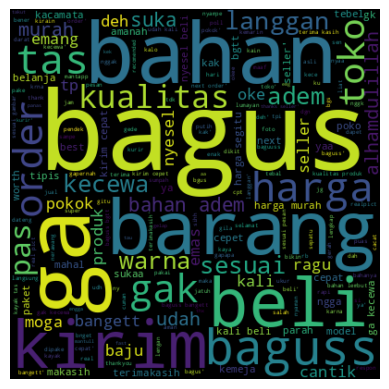

In [18]:
# Membuat wordcloud
text = data['reviews'][data['label']==1].values
wordcloud = WordCloud(width=400, height=400).generate(str(text))
# Menampilkan wordcloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

Berdasarkan wordcloud di atas, kata-kata seperti bagus, bahan, barang merupakan kata-kata yang sering muncul pada document dengan label positif. Hal ini mungkin disebabkan karena banyak konsumen yang memuji bahan dan barang. Berikutnya saya akan melihat kata yang sering muncul berdasarkan labelnya dimulai dari label negatif

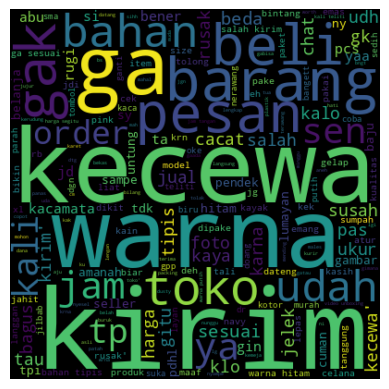

In [19]:
# Membuat wordcloud
text = data['reviews'][data['label']==0].values
wordcloud = WordCloud(width=400, height=400).generate(str(text))
# Menampilkan wordcloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

Berdasarkan wordcloud di atas, kata-kata kecewa, kirim, warna merupakan kata-kata yang sering muncul pada document dengan label negatif. Hal ini mungkin disebabkan karena banyak konsumen yang mengkritik pengiriman dan warna. Selanjutnya saya akan melakukan ann training

## 6. ANN Training (Sequential API/Functional API)

Pada bagian ini akan dilakukan training terhadap model artificial neural network(ann)

### Model Definition

Pada bagian ini akan dilakukan pendefinisian model. Model yang digunakan adalah long short-term memory(lstm). Model ini saya gunakan karena teks merupakan data sequensial dan model recurrent neuron seperti lstm merupakan model yang tepat dalam memproses data sequensial. Metrik yang digunakan adalah accuracy. Metrik ini saya gunakan karena dataset merupakan data balance dan pada kasus ini ketepatan model dalam memprediksi klasifikasi positif atau negatif merupakan hal terpenting

In [20]:
## Menghapus session
seed = 3
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)
## Membuat arsitektur model lstm
model_lstm_1 = Sequential()
model_lstm_1.add(text_vectorization)
model_lstm_1.add(embedding)
model_lstm_1.add(Bidirectional(LSTM(256, return_sequences=True)))
model_lstm_1.add(Bidirectional(LSTM(128)))
model_lstm_1.add((Dense(64)))
model_lstm_1.add(Dense(1, activation='sigmoid'))
model_lstm_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 39)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 39, 128)           233856    
                                                                 
 bidirectional (Bidirection  (None, 39, 512)           788480    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               656384    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                        

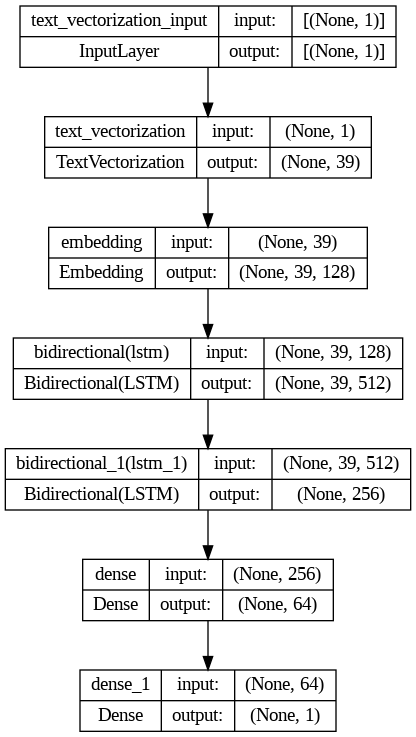

In [21]:
# Membuat model lstm
model_lstm_1.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
tf.keras.utils.plot_model(model_lstm_1, show_shapes=True)

### Model Training

Pada bagian ini akan dilakukan model training berdasarkan arsitektur yang telah ditentukan

In [22]:
%%time

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# Melakukan training terhadap model lstm
model_lstm_1_hist = model_lstm_1.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[callback])

Epoch 1/50
20/20 [==============================] - 21s 614ms/step - loss: 0.6563 - accuracy: 0.6073 - val_loss: 0.4800 - val_accuracy: 0.7465
Epoch 2/50
20/20 [==============================] - 10s 500ms/step - loss: 0.2260 - accuracy: 0.9164 - val_loss: 0.6278 - val_accuracy: 0.7465
Epoch 3/50
20/20 [==============================] - 9s 452ms/step - loss: 0.0816 - accuracy: 0.9716 - val_loss: 0.6923 - val_accuracy: 0.7606
Epoch 4/50
20/20 [==============================] - 10s 511ms/step - loss: 0.0236 - accuracy: 0.9937 - val_loss: 1.3085 - val_accuracy: 0.7887
Epoch 5/50
20/20 [==============================] - 10s 509ms/step - loss: 0.0211 - accuracy: 0.9968 - val_loss: 0.9821 - val_accuracy: 0.7606
Epoch 6/50
20/20 [==============================] - 10s 505ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 1.7557 - val_accuracy: 0.7324
CPU times: user 1min 46s, sys: 6.37 s, total: 1min 53s
Wall time: 1min 10s


Text(0.5, 1.0, 'Loss vs Val-Loss')

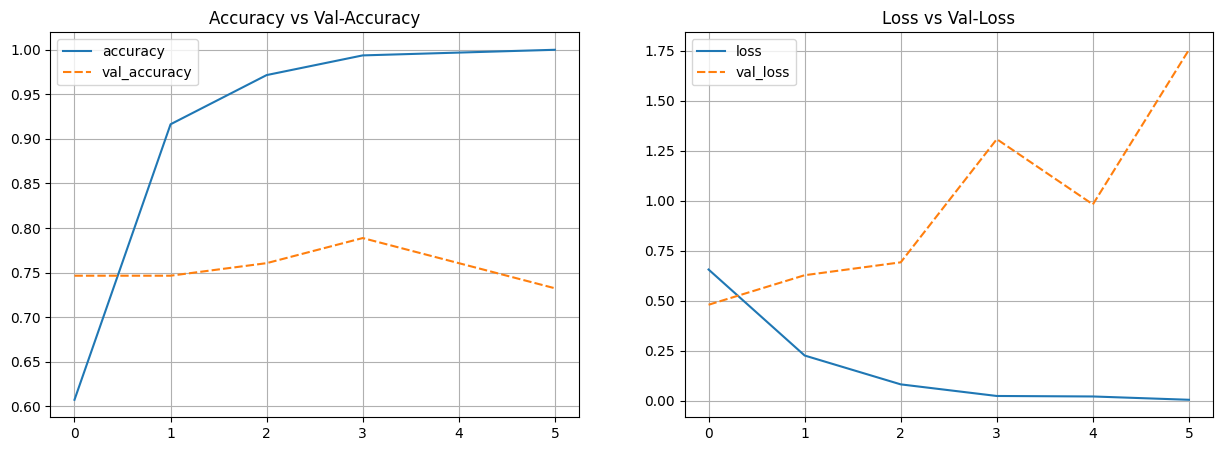

In [23]:
# Membuat history menjadi dataframe
history_lstm_df = pd.DataFrame(model_lstm_1_hist.history)
# Melihat plot accuracy dan loss
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.lineplot(data=history_lstm_df[['accuracy','val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.subplot(1,2,2)
sns.lineplot(data=history_lstm_df[['loss','val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

### Model Evaluation

Pada bagian ini akan dilakukan evaluasi terhadap model lstm

In [24]:
# Melihat prediksi model terhadap data training
y_pred_lstm_train = model_lstm_1.predict(X_train)
y_pred_lstm_train = np.where(y_pred_lstm_train >= 0.5, 1, 0)
print(classification_report(y_train, y_pred_lstm_train))

20/20 [==============================] - 4s 112ms/step
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       341
         1.0       1.00      1.00      1.00       293

    accuracy                           1.00       634
   macro avg       1.00      1.00      1.00       634
weighted avg       1.00      1.00      1.00       634



In [46]:
# Melihat prediksi model terhadap data testing
y_pred_lstm_test = model_lstm_1.predict(X_test)
y_pred_lstm_test = np.where(y_pred_lstm_test >= 0.5, 1, 0)
print(classification_report(y_test, y_pred_lstm_test))

4/4 [==============================] - 1s 266ms/step
              precision    recall  f1-score   support

         0.0       0.94      0.73      0.82        67
         1.0       0.75      0.95      0.84        58

    accuracy                           0.83       125
   macro avg       0.85      0.84      0.83       125
weighted avg       0.85      0.83      0.83       125



Berdasarkan hasil dari classification report di atas, model termasuk overfit karena memiliki nilai accuracy test yang cukup jauh lebih rendah dari accuracy training. Selanjutnya saya akan melakukan ann improvement

## 7. ANN Improvement (Sequential API/Functional API)

Pada bagian ini akan dilakukan peningkatan dari model sebelumnya

### Model Definition

Pada bagian ini akan dilakukan pendefinisian model. Saya akan mencoba meningkatkan performa model dengan menambahkan dropout dan mengurangi jumlah layer dan neuron. Saya menambahkan dropout karena dropout membuat neuron tidak terlalu bergantung terhadap satu neuron sehingga dapat mempelajari fitur lain dan dapat mempercepat waktu training.

In [26]:
## Menghapus session
seed = 3
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)
## Membuat arsitektur model lstm_2
model_lstm_2 = Sequential()
model_lstm_2.add(text_vectorization)
model_lstm_2.add(embedding)
model_lstm_2.add(Bidirectional(LSTM(128, return_sequences=True)))
model_lstm_2.add(Dropout(0.1))
model_lstm_2.add(Bidirectional(LSTM(64)))
model_lstm_2.add(Dropout(0.1))
model_lstm_2.add(Dense(1, activation='sigmoid'))
model_lstm_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 39)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 39, 128)           233856    
                                                                 
 bidirectional (Bidirection  (None, 39, 256)           263168    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 39, 256)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                        

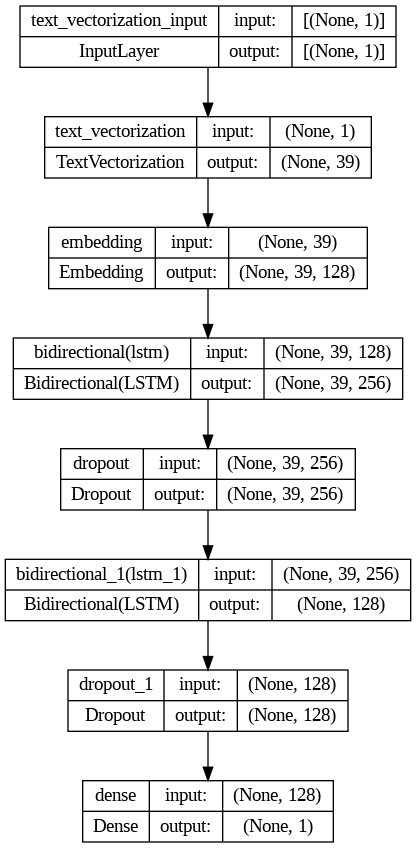

In [27]:
# Membuat model lstm
model_lstm_2.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
tf.keras.utils.plot_model(model_lstm_2, show_shapes=True)

### Model Training

Pada bagian ini akan dilakukan model training berdasarkan arsitektur yang telah ditentukan

In [28]:
%%time

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# Melakukan training terhadap model lstm
model_lstm_2_hist = model_lstm_2.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[callback])

Epoch 1/50
20/20 [==============================] - 16s 369ms/step - loss: 0.4437 - accuracy: 0.7681 - val_loss: 0.7184 - val_accuracy: 0.7887
Epoch 2/50
20/20 [==============================] - 4s 195ms/step - loss: 0.0841 - accuracy: 0.9826 - val_loss: 1.2355 - val_accuracy: 0.7465
Epoch 3/50
20/20 [==============================] - 4s 197ms/step - loss: 0.0465 - accuracy: 0.9905 - val_loss: 1.0603 - val_accuracy: 0.7465
Epoch 4/50
20/20 [==============================] - 5s 259ms/step - loss: 0.0212 - accuracy: 0.9953 - val_loss: 1.2764 - val_accuracy: 0.7183
Epoch 5/50
20/20 [==============================] - 4s 195ms/step - loss: 0.0171 - accuracy: 0.9968 - val_loss: 1.0407 - val_accuracy: 0.7606
Epoch 6/50
20/20 [==============================] - 4s 194ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 1.5020 - val_accuracy: 0.7042
CPU times: user 52.1 s, sys: 2.51 s, total: 54.7 s
Wall time: 36.6 s


Text(0.5, 1.0, 'Loss vs Val-Loss')

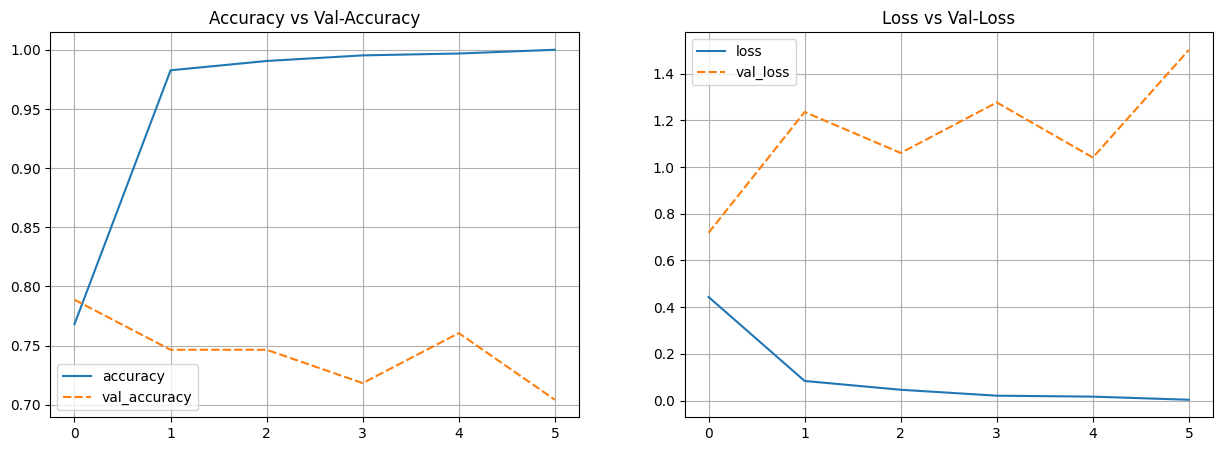

In [29]:
# Membuat history menjadi dataframe
history_lstm2_df = pd.DataFrame(model_lstm_2_hist.history)
# Melihat plot accuracy dan loss
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.lineplot(data=history_lstm2_df[['accuracy','val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.subplot(1,2,2)
sns.lineplot(data=history_lstm2_df[['loss','val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

### Model Evaluation

Pada bagian ini akan dilakukan evaluasi terhadap model lstm

In [30]:
# Melihat prediksi model terhadap data training
y_pred_lstm2_train = model_lstm_2.predict(X_train)
y_pred_lstm2_train = np.where(y_pred_lstm2_train >= 0.5, 1, 0)
print(classification_report(y_train, y_pred_lstm2_train))

20/20 [==============================] - 4s 75ms/step
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       341
         1.0       1.00      1.00      1.00       293

    accuracy                           1.00       634
   macro avg       1.00      1.00      1.00       634
weighted avg       1.00      1.00      1.00       634



In [31]:
# Melihat prediksi model terhadap data testing
y_pred_lstm2_test = model_lstm_2.predict(X_test)
y_pred_lstm2_test = np.where(y_pred_lstm2_test >= 0.5, 1, 0)
print(classification_report(y_test, y_pred_lstm2_test))

4/4 [==============================] - 0s 57ms/step
              precision    recall  f1-score   support

         0.0       0.96      0.72      0.82        67
         1.0       0.75      0.97      0.84        58

    accuracy                           0.83       125
   macro avg       0.85      0.84      0.83       125
weighted avg       0.86      0.83      0.83       125



Berdasarkan hasil dari classification report di atas, model termasuk overfit karena memiliki nilai accuracy test yang cukup jauh lebih rendah dari accuracy training. Walaupun begitu, waktu training menjadi lebih cepat dari 1 menit 10 detik menjadi 36 detik saja dengan hasil klasifikasi yang sama

## 8. Model Saving

Berdasarkan hasil model evaluation, model improvement memiliki waktu training lebih cepat dan loss lebih rendah dari model base. Saya memutuskan untuk menyimpan model improvement. Sebelum melakukan penyimpanan model, saya akan mengubah model menjadi non-trainable

In [32]:
# Melihat arsitektur model functional
model_lstm_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 39)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 39, 128)           233856    
                                                                 
 bidirectional (Bidirection  (None, 39, 256)           263168    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 39, 256)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                        

In [33]:
# Membekukan model
model_lstm_2.trainable = False

In [34]:
# Melihat arsitektur model functional
model_lstm_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 39)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 39, 128)           233856    
                                                                 
 bidirectional (Bidirection  (None, 39, 256)           263168    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 39, 256)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                        

In [35]:
# Menyimpan model
model_lstm_2.save('model_lstm.keras', save_format="keras")

Selanjutnya saya akan melakukan model inference

## 9. Model Inference

Pada bagian ini akan dilakukan prediksi data inference menggunakan model yang telah disimpan

In [39]:
# Membuat data inference
data_inf = {'reviews':'Pengiriman lama produknya juga ga sesuai dengan gambar kecewa berat'}
data_inf = pd.DataFrame([data_inf])
data_inf

,reviews
0,Pengiriman lama produknya juga ga sesuai denga...


In [40]:
# Melakukan praproses teks pada kolom reviews
data_inf['reviews'] = data_inf['reviews'].apply(lambda x: praproses_text(x))
data_inf

,reviews
0,kirim produk ga sesuai gambar kecewa berat


In [41]:
# Melakukan prediksi terhadap data inference
y_pred_inf = model_lstm_2.predict(data_inf)
y_pred_inf = np.where(y_pred_inf >= 0.5, 1, 0)
if y_pred_inf == 1:
    print('Review Positif')
else:
    print('Review Negatif')

1/1 [==============================] - 0s 33ms/step
Review Negatif


In [48]:
# Membuat data inference
data_inf = {'reviews':'Suka banget sama produknya pokoknya rekomended banget deh belanja disini'}
data_inf = pd.DataFrame([data_inf])
data_inf

,reviews
0,Suka banget sama produknya pokoknya rekomended...


In [49]:
# Melakukan praproses teks pada kolom reviews
data_inf['reviews'] = data_inf['reviews'].apply(lambda x: praproses_text(x))
data_inf

,reviews
0,suka produk pokok rekomended deh belanja


In [50]:
# Melakukan prediksi terhadap data inference
y_pred_inf = model_lstm_2.predict(data_inf)
y_pred_inf = np.where(y_pred_inf >= 0.5, 1, 0)
if y_pred_inf == 1:
    print('Review Positif')
else:
    print('Review Negatif')

1/1 [==============================] - 0s 69ms/step
Review Positif


## 10. Pengambilan Kesimpulan

Pada bagian ini akan dilakukan pengambilan kesimpulan berdasarkan hasil yang telah didapatkan

### Kesimpulan

Text(0.5, 1.0, 'Loss vs Val-Loss')

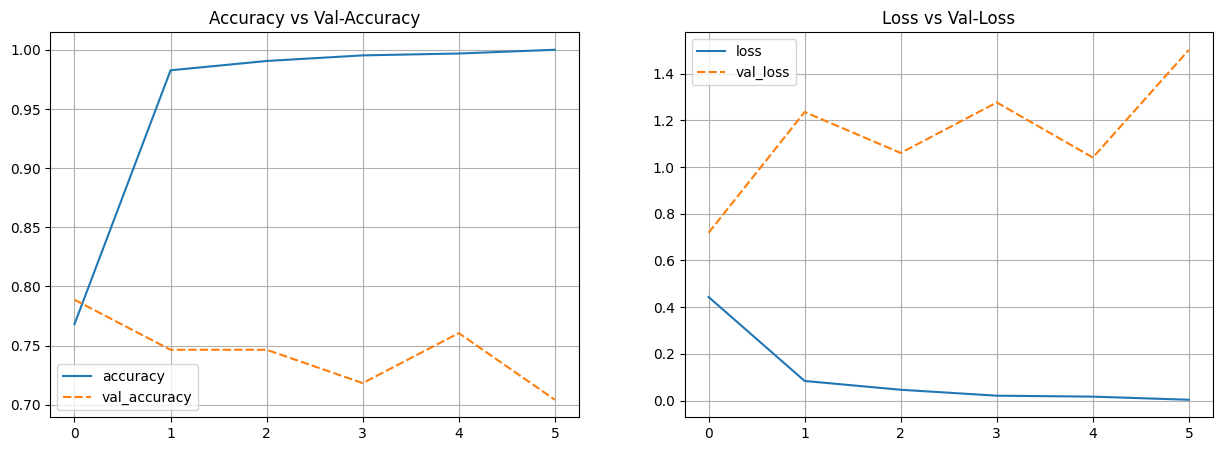

In [47]:
# Membuat history menjadi dataframe
history_lstm2_df = pd.DataFrame(model_lstm_2_hist.history)
# Melihat plot accuracy dan loss
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.lineplot(data=history_lstm2_df[['accuracy','val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.subplot(1,2,2)
sns.lineplot(data=history_lstm2_df[['loss','val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

Berdasarkan model evaluasi dan inference yang telah dilakukan, model berhasil melakukan klasifikasi positif atau negatif. Namun berdasarkan plot di atas, model termasuk overfit karena memiliki validation accuracy yang jauh lebih rendah dari training accuracy. Model juga memiliki nilai loss yang cukup tinggi

### Saran

Disarankan dalam pembuatan model selanjutnya dapat melakukan pengubahan kata-kata slang dan singkatan menjadi kata yang baku sehingga dapat meningkatkan performa klasifikasi. Bisa juga menggunakan text vectorization yang lain seperti word2vec agar model dapat lebih menangkap makna semantik dan hubungan dari kata-kata